<a href="https://colab.research.google.com/github/karanpdx/UW-PHYS417/blob/main/Lab_7_Karan_(unfinished).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7 Report:
## German-to-English Translation with Attention-Mechanism Transformer Model

In [7]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import spacy

# Initialize your numpy and pytorch random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a torch.device object to tell pytorch where to store your tensors: cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define a tokenizer function using spaCy
def tokenize(text):
    return [token.text for token in nlp(text)]

# Build vocabulary function (similar to torchtext's build_vocab_from_iterator)
def build_vocab(text_iterator, min_freq=2):
    vocab = {}
    for text in text_iterator:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1

    return {word: i for i, (word, freq) in enumerate(vocab.items()) if freq >= min_freq}

# You might need to download the spaCy model if not already present
# Uncomment the following lines if needed:
# import spacy.cli
# spacy.cli.download("en_core_web_sm")


/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
from IPython.display import Image # For displaying images in colab jupyter cell

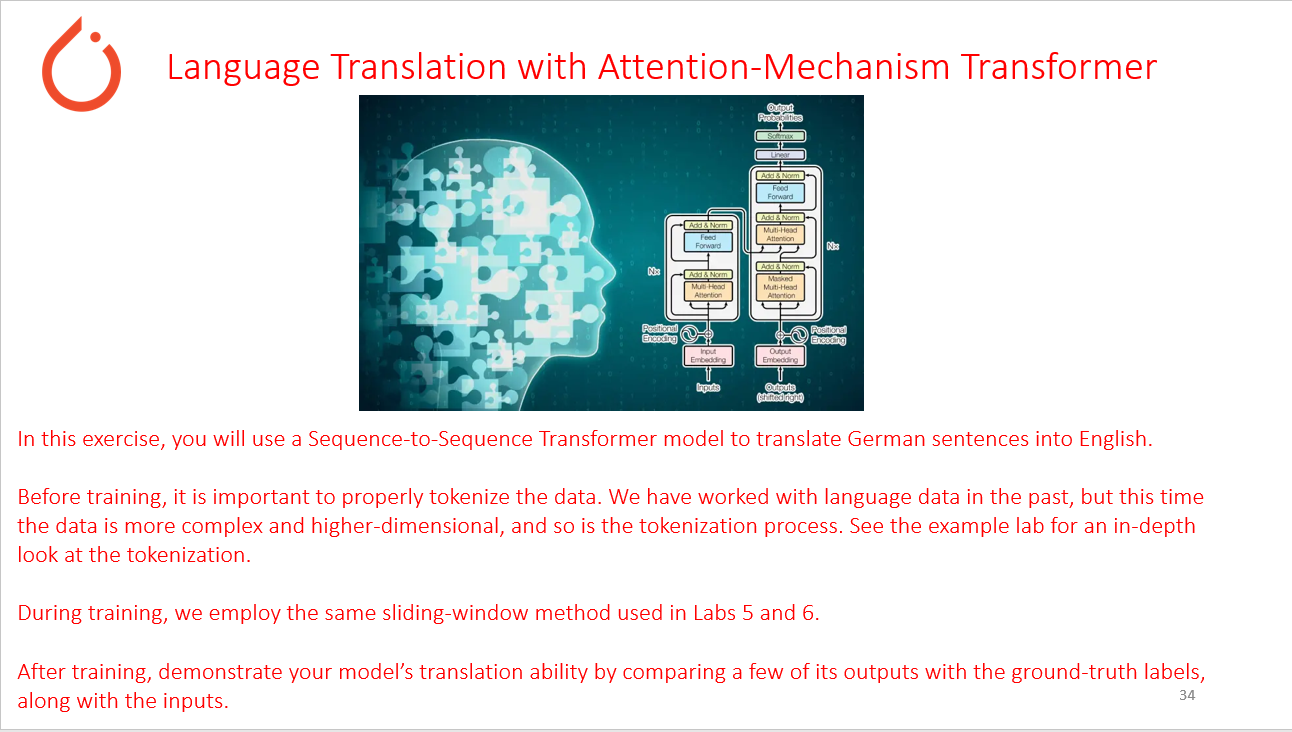

In [ ]:
Image('lab7_exercise.png', width = 1000)

In [ ]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Download data

In [ ]:
# Load the data and store it as a list of tuples: each element in the list should be a tuple of the form (german_sentence, english_sentence)
# YOUR CODE HERE

## Let's see what the data looks like

In [ ]:
# Print the first ten translated lines
# YOUR CODE HERE

## Create source and target language tokenizers

But first, what exactly is a *tokenizer*?

A short but incomplete summary is that a tokenizer converts your text/string into a list of numerical values (a list of *tokens*). We performed tokenization in Lab 5 when we converted each alphanumeric character in our text into a number (an index in a dictionary).

Here, the tokenization is a bit different. Instead of converting each *character* into a number, we want to convert each *word* into a number. As you can imagine, this means the vocabulary of our dataset - the set of unique tokens it contains - will be much larger. There are many more words in English than there are letters! This also means the value of each token will be more unique and meaningful.

Part of tokenizing at the word level is the process of standardizing the text by converting it to lowercase, removing punctuation or special characters, and dealing with contractions or other language-specific features. This is sometimes called *stemming*, reflecting the fact that we want to only extract the *essential meaning* of each word - the "stem" - not necessarily the punctuation, prefixes, suffixes, etc. surrounding it.

Luckily for us, there are some existing Python packages that do this automatically. The below cell downloads two different tokenizers (one each for the source and larget languages), and assigns them to appropriate keys within the "token_transform" dictionary.
In Lab 5, you performed tokenization when you converted each character of the text into a specific number.

In [ ]:
# Define MACRO - a high-level variable that won't change throughout the duration of the code - for your source and target languages
# YOUR CODE HERE


# Download the German and English tokenizers, and assign them to appropriate keys in your token_transform dictionary
# YOUR CODE HERE

## Let's see what these specific tokenizers do.

In [ ]:
# Tokenize the first line of each dataset, and print the tokenized version of it
# YOUR CODE HERE

## Create a vocabulary for each language's dataset

In Lab 5, we did this with a simple dictionary that mapped each character to an integer (and vice versa). However, PyTorch has a built-in dictionary object that provides some extra functionality.

We will create this object using torchtext.data.build_vocab_from_iterator(). This function takes an iterator as input and returns a torchtext.vocab.Vocab object. This is a dictionary-like object that maps tokens to indices, but where it differs from a normal dictionary, is that its indices are assigned based on the frequency of the tokens in the dataset. For example, the most frequent token gets the index 0, the second most frequent gets the index 1, and so on. This frequency-index mapping saves a bunch of compute time and resources.


Moreover, this time we will also have the four "special" tokens, that will always be assigned to the first four indices.

In [ ]:
# Define a helper function that converts a list of strings into a list of lists-of-tokens
# YOUR CODE HERE

# Define your special tokens and their indeces in your vocabulary
# YOUR CODE HERE

# Define your vocabulary for each language using the build_vocab_from_iterator function
# YOUR CODE HERE

# Set ``UNK_IDX`` as the default index.
# YOUR CODE HERE

# Let's see the first 20 words in each vocabulary
 # YOUR CODE HERE

## Train-Validate-Test split

In [ ]:
# Shuffle the text pairs
# YOUR CODE HERE

# Let's go for a 70-20-10 train-val-test split
# YOUR CODE HERE

# YOUR CODE HERE

# YOUR CODE HERE

# Check the size of each data set
# YOUR CODE HERE

### Mask functions

The mask function plays an essential role in the training of a transformer model, specifically during the pre-training phase when the model learns to understand and generate language. The two main purposes of the mask function are:

1. To facilitate self-attention mechanism: Transformers use self-attention mechanisms to identify relationships between words in a sequence. Masking is used to prevent the model from "cheating" by looking at future tokens when trying to predict the current token. In other words, the mask function ensures that the model only attends to the current token and the previous tokens, not the future tokens, during the training process.

2. To enable masked language modeling (MLM): Masked language modeling is a popular pre-training objective used in transformer-based models like BERT. In MLM, a certain percentage of input tokens are randomly masked (usually around 15%), and the model is tasked with predicting the original tokens at these masked positions. The mask function serves as a way of hiding the original token from the model, forcing it to learn contextual representations that can help it predict the masked tokens accurately.

The use of the mask function in both self-attention and MLM helps the transformer model learn meaningful context-dependent representations, making it more effective at understanding and generating natural language.

In [ ]:
# Define your masking function
# YOUR CODE HERE

## Collation

The collation function is what converts our strings into batches of tensors that can be processed by our model, based on the vocabularies and tokenization functions we have built up thus far.

Again, this is something we can do manually, but at some point the data transformations get so complicated that we might as well put them all into a function. Moreover, defining our transformation as a *function* allows us to use some more built-in PyTorch functionality that makes our jobs a whole lot easier. See: torch.utils.data.DataLoader.

In [ ]:
# Define helper function to club together sequential operations
# YOUR CODE HERE

# Define function to add BOS/EOS and create a tensor for input sequence indices
# YOUR CODE HERE

# Define your ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
# YOUR CODE HERE

# Define your "collation" function to collate data samples into batch tensors
# YOUR CODE HERE

# Define training, evaluation functions

Modularization is the name of the game.

Not only does this help us here, but if you ever need to train a similar model in the future, you can simply import the ones defined here!

For example, imagine this was a Python script and not a notebook, and the filename was "german_to_english_transformer.py" Then, in whichever future script or notebook you wish to use these functions, you could simply call:
"from german_to_english_transformer import train_epoch, evaluate"

In [ ]:
# Define a function to train the model for a single epoch
# YOUR CODE HERE

# Define a function to evaluate the model
# YOUR CODE HERE

## Define model

In [ ]:
# Define the PositionalEncoding module that quantifies the relative position of words in a sentence
# Notice that this is not actually an MLP or neural network, i.e. it has no learned parameters
# it is just a function that you could represent analytically, if you wanted to
# YOUR CODE HERE

# Define the TokenEmbedding module converts a tensor of vocabulary-indices into a tensor of token-embeddings
# Also not a neural network, but a lookup table
# YOUR CODE HERE

# Define the actual transformer model
# Question: What are we "transforming" between?
# YOUR CODE HERE

## Question #2: What's the significance of the "num_heads" parameter in the __init__ function of the Seq2SeqTransformer above?

Your answer here

## Question #3: In less detail, state the significance of these other two parameters:

1. embedding_size
2. src_vocab_size

## Define hyperparameters

In [ ]:
# Define your hyperparameters
# YOUR CODE HERE

# Define your model, loss function, and optimizer
# YOUR CODE HERE

## Identify tracked values

In [ ]:
# YOUR CODE HERE

## Train the model

In [ ]:
# Train your model
# YOUR CODE HERE

# Fair warning: you might get an "out of memory" error
# If that happens, try reducing the batch size

## Visualize and Evaluate the model

In [ ]:
# Plot the loss
# YOUR CODE HERE

In [ ]:
# Define a decode function to generate output sequence using greedy algorithm
# This basically saves us some compute time by taking a bunch of shortcuts (e.g. not computing the full softmax)
# YOUR CODE HERE

# Define a translation function that actually uses the model to translate a sentence from source to target
# YOUR CODE HERE

## Let's try the model out on a few of our test sequences. Print the first 10 target/translated sequences from our test set

In [ ]:
# YOUR CODE HERE